In [1]:
pwd

'/global/u2/c/caditi97/exatrkx-ctd2020'

In [2]:
import time
import pickle
import logging
import argparse

import sys
import os
import numpy as np
import pandas as pd
import functools
import seaborn as sns

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool as ProcessPool 

from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Pick up local packages
sys.path.append('..')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import trackml.dataset

sys.path.append('/global/homes/c/caditi97/exatrkx-ctd2020/MetricLearning/src/preprocess_with_dir/')
# from extract_dir import *
from preprocess import get_one_event, load_detector

In [3]:
dir_path = "/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events"
event_path = os.path.join(dir_path, "event000001005")

In [4]:
hits, cells, particles, truth = trackml.dataset.load_event(event_path)
print("----Original----")
print("hits")
print(hits.shape)
print("cells")
print(cells.shape)
print("truth")
print(truth.shape)

----Original----
hits
(110023, 7)
cells
(608716, 4)
truth
(110023, 9)


In [5]:
detector_path = "/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/detectors.csv"
detector_orig, detector_proc = load_detector(detector_path)
include_endcaps = False
include_noise = 1.0
pt_cut = 1
event = get_one_event(event_path,detector_orig,detector_proc,include_endcaps,include_noise,pt_cut)

Loading detector...
Detector loaded.


In [6]:
event

[       hit_id           x            y            z  volume_id  layer_id  \
 0       15226   24.015301   -21.368000  -457.464996          8         2   
 1       15230   24.612400   -22.487700  -460.074005          8         2   
 2       15249  -29.916000    -9.694790  -408.864014          8         2   
 3       15268   31.036900    12.447200  -363.156006          8         2   
 4       15273  -32.883701    -2.706810  -281.904999          8         2   
 ...       ...         ...          ...          ...        ...       ...   
 17057  107202  341.079010   964.844971   981.400024         17         4   
 17058  107228 -174.201996  1004.409973  1035.400024         17         4   
 17059  107229 -306.402008   973.646973  1035.400024         17         4   
 17060  107250 -821.440979   608.112000  1035.400024         17         4   
 17061  107260 -934.679993   405.937988  1078.599976         17         4   
 
        module_id  cell_count  cell_val      leta      lphi    lx        l

In [7]:
def remove_perc_noise(hits, cells, truth, perc = 1.0):
    if perc >= 1.0:
        return hits,cells,truth
    
    unique_ids = truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]
    noise_hits = unique_ids[np.where(unique_ids == 0)]
    where_to_keep = truth['particle_id'].isin(track_ids_to_keep)
    hits_reduced  = hits[where_to_keep]
    hit_ids_red = hits_reduced.hit_id.values
    noise_ids = hits[~where_to_keep].hit_id.values
    
    if perc <= 0.0:
        noise_ids = []
    else:
        num_rows = int(perc * noise_ids.shape[0])
        noise_ids = np.random.permutation(noise_ids)[:num_rows]

   
    
    #add noise
    hits_ids_noise = np.concatenate([hit_ids_red, noise_ids])
    
    noise_hits = hits[hits['hit_id'].isin(hits_ids_noise)]
    noise_truth = truth[truth['hit_id'].isin(hits_ids_noise)]
    noise_cells = cells[cells['hit_id'].isin(noise_truth.hit_id.values)]
    
    return noise_hits, noise_cells, noise_truth



In [8]:
print("----Original----")
print("hits")
print(hits.shape)
print("cells")
print(cells.shape)
print("truth")
print(truth.shape)

----Original----
hits
(110023, 7)
cells
(608716, 4)
truth
(110023, 9)


In [15]:
perc = 0.6
noise_hits, noise_cells, noise_truth = remove_perc_noise(hits,cells,truth,perc)
print("----" + str(perc) + " Noise----")
print("hits")
print(noise_hits.shape)
print("cells")
print(noise_cells.shape)
print("truth")
print(noise_truth.shape)

----0.6 Noise----
hits
(102901, 7)
cells
(571047, 4)
truth
(102901, 9)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


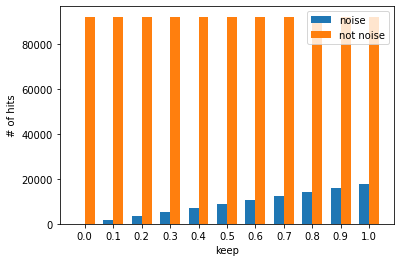

In [12]:
#Ami's plot
pt = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
particles = particles.assign(pt=pt)
keeps = np.arange(0.0, 1.1, 0.1)
print(keeps)

noise_hits = []
not_noise_hits = []

for i in keeps:
    _, _, reduced_truth = remove_perc_noise(hits, cells, truth, i)
    n_noise = sum(reduced_truth['particle_id'] == 0)
    noise_hits.append(n_noise)
    not_noise_hits.append(len(reduced_truth) - n_noise)

x = np.arange(len(keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noise_hits, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise_hits, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('keep')
ax.set_xticks(x)
labels = ['%.1f' % (i,) for i in keeps]
ax.set_xticklabels(labels)
ax.legend()

Text(0.5, 1.0, 'All Hits')

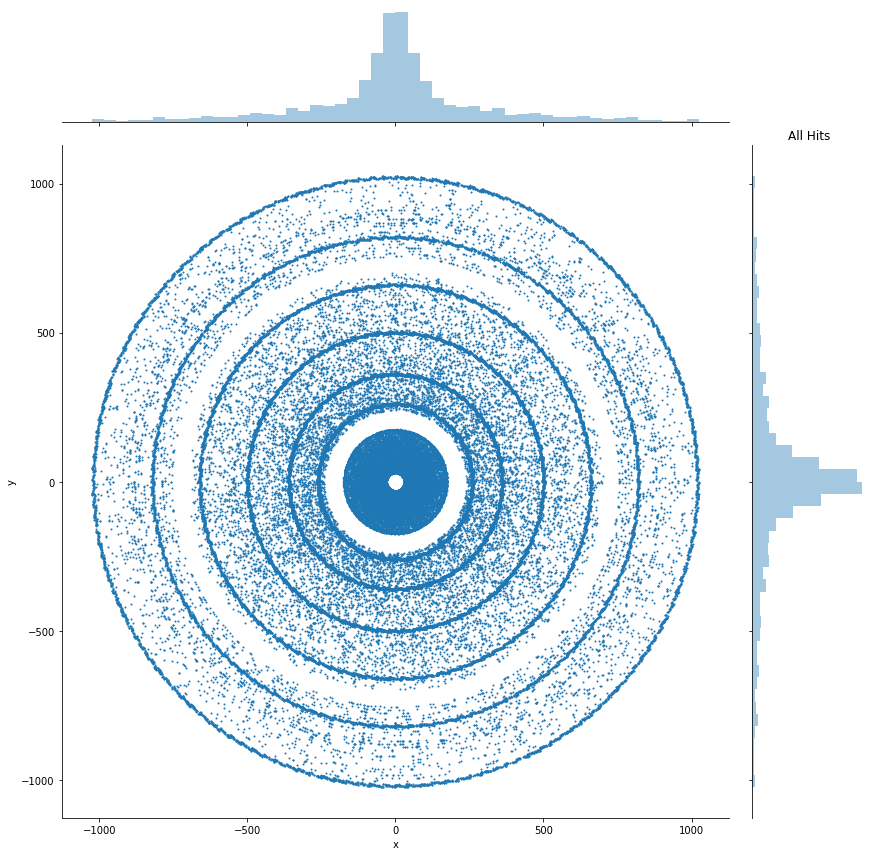

In [35]:
g1 = sns.jointplot(hits.x, hits.y, s=1, height=12)
plt.title('All Hits')

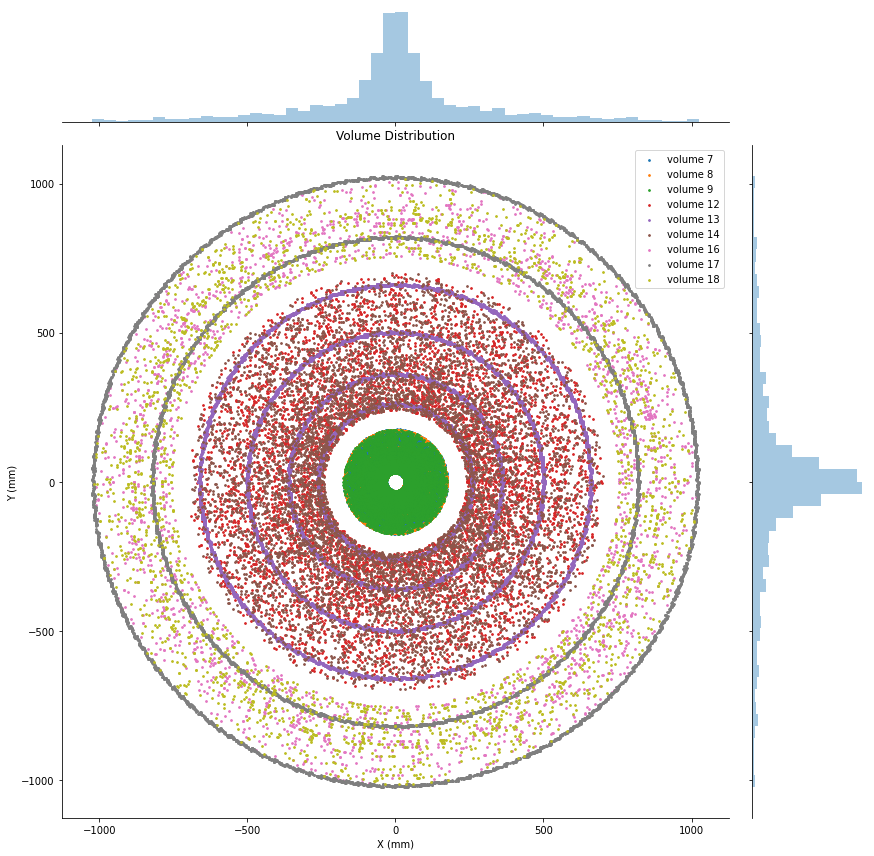

In [36]:
g2 = sns.jointplot(hits.x, hits.y, s=1, height=12)
g2.ax_joint.cla()
plt.sca(g2.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))
    
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.title('Volume Distribution')
plt.show()

In [84]:
def plot_noise(hits,cells,truth,perc):
    noise_hits, noise_cells, noise_truth = remove_perc_noise(hits,cells,truth,perc)
    print("----" + str(perc) + " Noise----")
    print("hits")
    print(noise_hits.shape)
    print("cells")
    print(noise_cells.shape)
    print("truth")
    print(noise_truth.shape)

    unique_ids = noise_truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]
    where_to_keep = noise_truth['particle_id'].isin(track_ids_to_keep)
    not_noise  = noise_hits[where_to_keep]
    noise = noise_hits[~where_to_keep]

    g3 = sns.jointplot(not_noise.x, not_noise.y, s=2, height=12, label = "not noise")
    g3.x = noise.x
    g3.y = noise.y
    g3.plot_joint(plt.scatter, c='r', s=1, label = "noise")



    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.legend()
    plt.title('Noise Distribution')
    plt.show()

----0.0 Noise----
hits
(92218, 7)
cells
(515209, 4)
truth
(92218, 9)


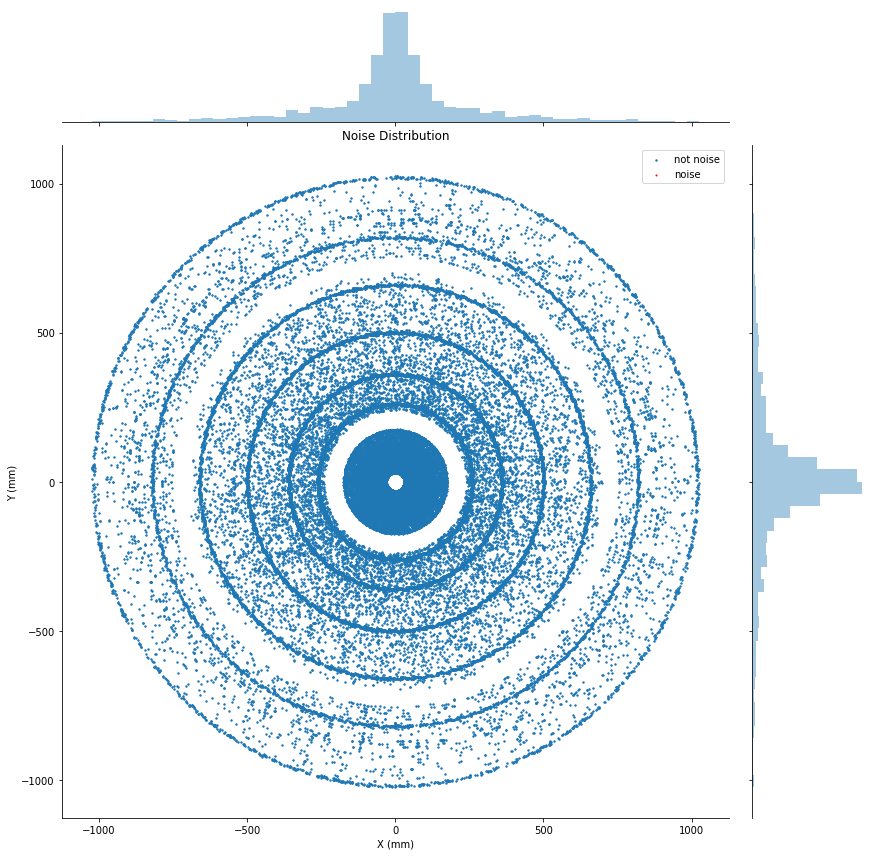

In [85]:
plot_noise(hits,cells,truth,0.0)

----0.2 Noise----
hits
(95779, 7)
cells
(533869, 4)
truth
(95779, 9)


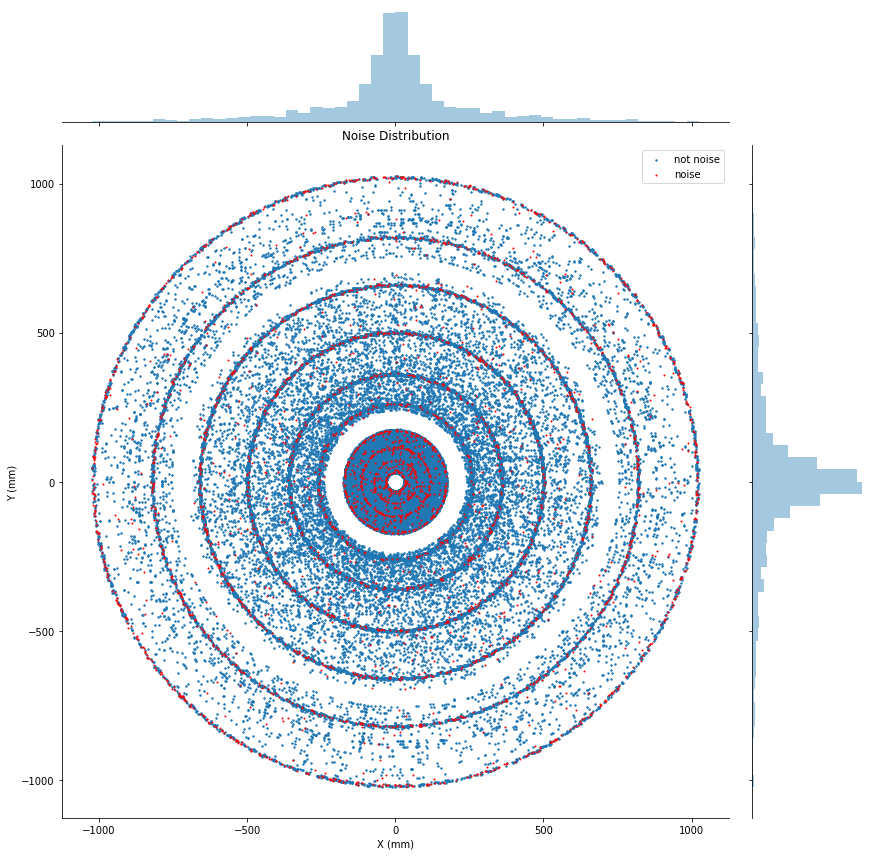

In [86]:
plot_noise(hits,cells,truth,0.2)

----0.5 Noise----
hits
(101120, 7)
cells
(561820, 4)
truth
(101120, 9)


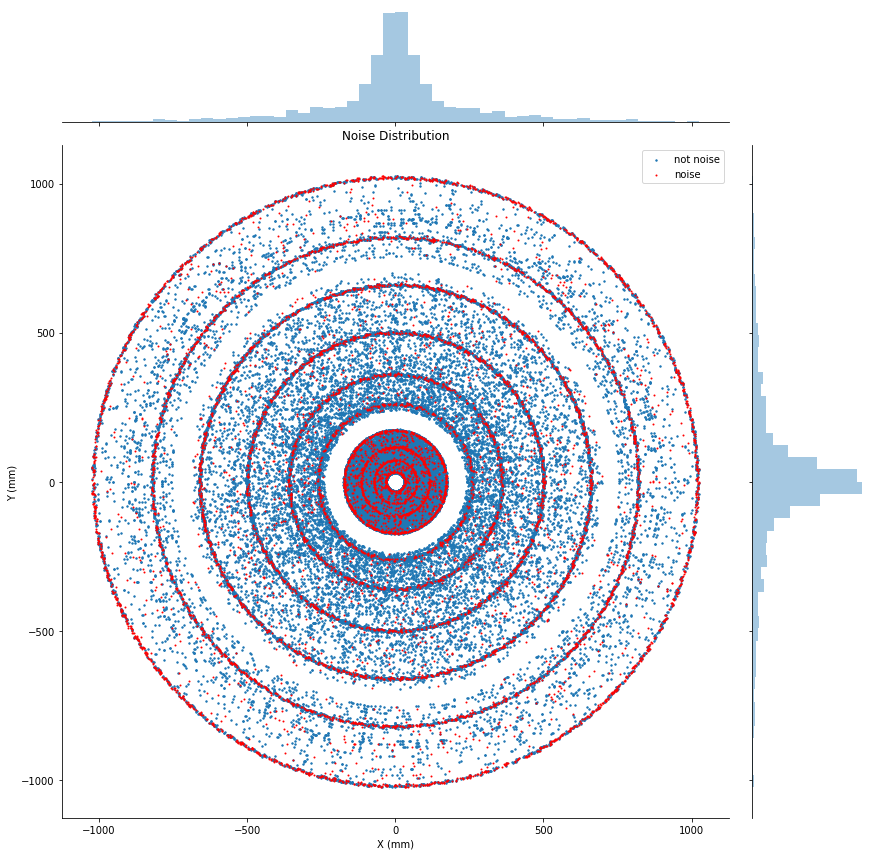

In [87]:
plot_noise(hits,cells,truth,0.5)

----0.8 Noise----
hits
(106462, 7)
cells
(590010, 4)
truth
(106462, 9)


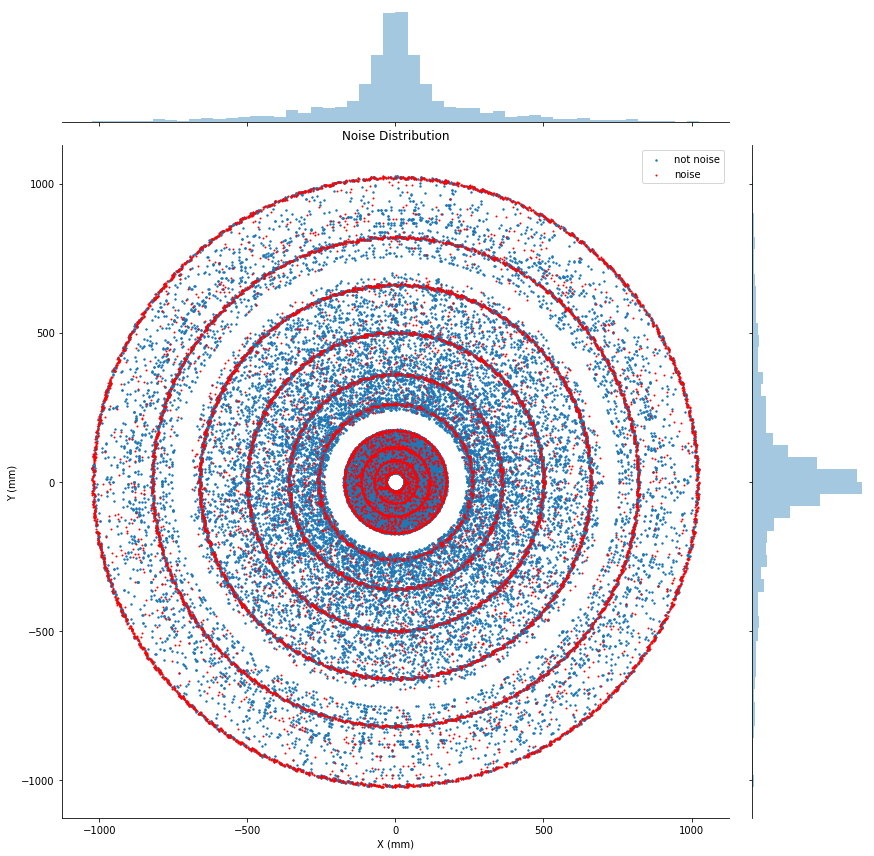

In [88]:
plot_noise(hits,cells,truth,0.8)

----1 Noise----
hits
(110023, 7)
cells
(608716, 4)
truth
(110023, 9)


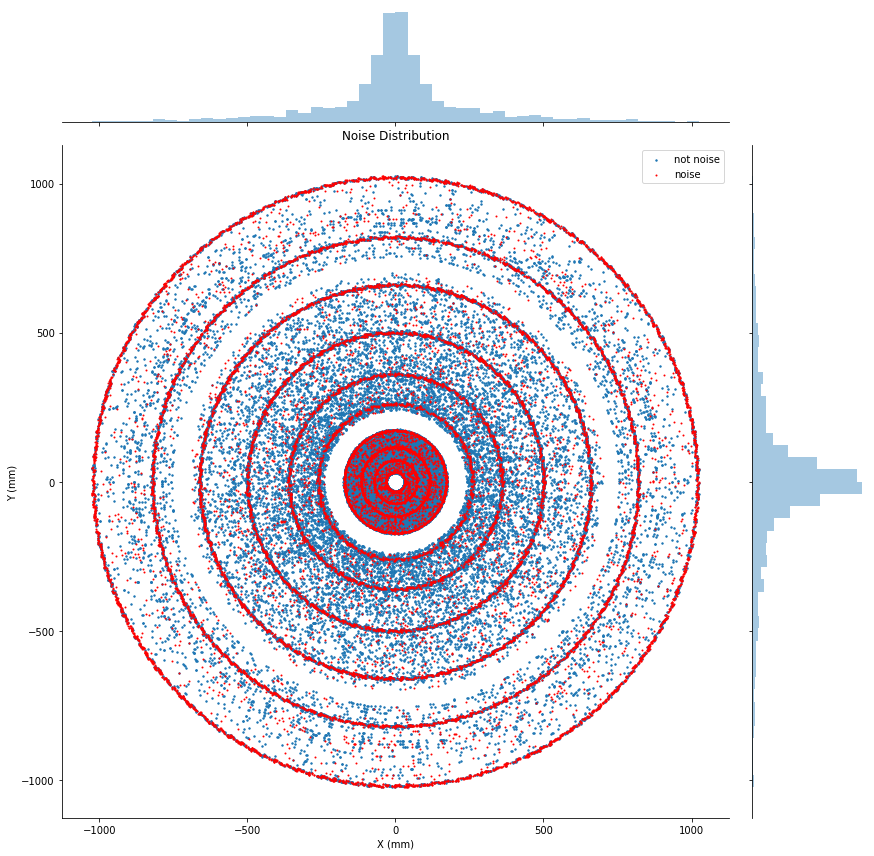

In [89]:
plot_noise(hits,cells,truth,1)

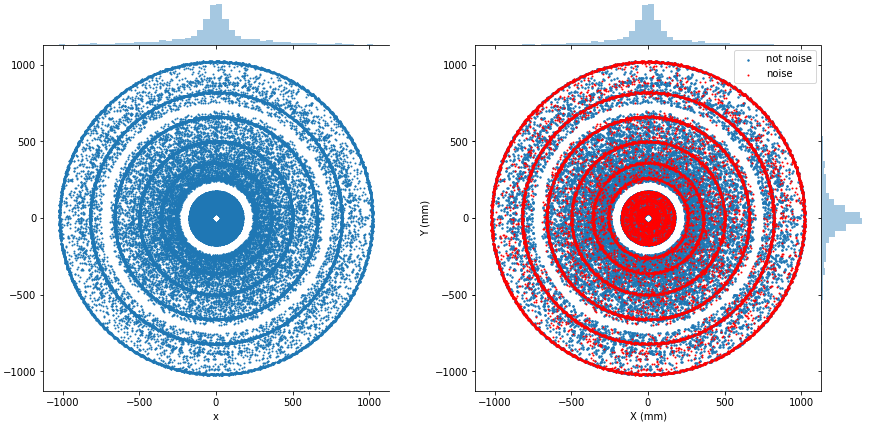

In [45]:
#subplots migration
f = plt.figure()
for g in [g1,g3]:
    for A in g.fig.axes:
        f._axstack.add(f._make_key(A), A)

#subplots size adjustment
f.axes[0].set_position([0.05, 0.05, 0.4,  0.4])
f.axes[1].set_position([0.05, 0.45, 0.4,  0.05])
f.axes[2].set_position([0.55, 0.05, 0.05, 0.4])
f.axes[3].set_position([0.55, 0.05, 0.4,  0.4])
f.axes[4].set_position([0.55, 0.45, 0.4,  0.05])
f.axes[5].set_position([0.95, 0.05, 0.05, 0.4])

# Check Performance

In [78]:
# Pick up local packages
sys.path.append('..')
sys.path.append('global/homes/c/caditi97/exatrkx-ctd2020/MetricLearning/src/metric_learning_adjacent/')

# Local imports
from build_graphs import *
from GraphLearning.src.trainers import get_trainer
from utils.data_utils import (get_output_dirs, load_config_file, load_config_dir, load_summaries,
                      save_train_history, get_test_data_loader,
                      compute_metrics, save_metrics, draw_sample_xy)

In [66]:
config_file = '/global/homes/c/caditi97/exatrkx-ctd2020/GraphLearning/configs/pipeline_train_example.yaml'
config = load_config_file(config_file)
print('\nConfiguration: \n', config)


Configuration: 
 {'name': 'Training_Example_0', 'data_storage_path': '/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/', 'raw_data_path': '/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events', 'detector_path': '/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/detectors.csv', 'pt_cut': 1, 'nb_train': 1000000, 'nb_valid': 500000, 'nb_test': 500000, 'nb_layer': 3, 'nb_hidden': 512, 'emb_dim': 8, 'batch_size': 2000, 'lr_start': 0.001, 'max_nb_epochs': 20, 'doublet_output_dir': '/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020', 'emb_radius': 0.4, 'filter_threshold': 0.95, 'num_phi_sections': 8, 'embed_feats': False, 'augmented': False, 'doublet_threshold': 0.1, 'include_scores': True, 'doublet': {'resume': False, 'trainer': {'name': 'gnn_sparse'}, 'data': {'name': 'hitgraphs_sparse', 'n_train': 500, 'n_valid': 100, 'real_weight': 2.5, 'batch_size': 4, 'n_workers': 4}, 'model': {'name': 'resgnn', 'input_dim': 3, 'hidden_dim': 64, 'hidden_activatio

In [51]:
summaries_doublet, summaries_triplet = load_summaries(config)
print('\nDoublet training summaries: \n', summaries_doublet)
print('\nTriplet training summaries: \n', summaries_triplet)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/artifacts/Training_Example_0/doublet_gnn/summaries_0.csv'

In [53]:
artifact_dir_doublet, artifact_dir_triplet = get_output_dirs(config)
print(artifact_dir_doublet)

/global/cfs/projectdirs/m3443/usr/caditi97/exatrkx2020/artifacts/Training_Example_0/doublet_gnn


In [55]:
artifact_dir_doublet = 'global/cfs/projectdirs/m3443/usr/aoka/data/artifacts'

In [56]:
# Run Doublet GNN Performance metrics

best_idx_doublet = 19

# Build the trainer and load best checkpoint
trainer_doublet = get_trainer(output_dir=artifact_dir_doublet, gpu=0, **config['doublet']['trainer'])
trainer_doublet.build_model(optimizer_config=config['doublet']['optimizer'], **config['doublet']['model'])

best_epoch_doublet = 19
trainer_doublet.load_checkpoint(checkpoint_id=best_epoch_doublet)

print(trainer_doublet.model)
print('Parameters:', sum(p.numel() for p in trainer_doublet.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

In [92]:
# get neighbors 
feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']
neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
neighbors

In [95]:
artifact_storage_path = "/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_0"
best_emb_path = '/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_0/metric_learning_emb/best_model.pkl'
best_filter_path = '/global/cfs/cdirs/m3443/usr/aoka/data/artifacts/Training_Example_0/metric_learning_filter/best_model.pkl'   
    
emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
emb_model.eval()
filter_model.eval()

Edge_MLP(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (act1): ReLU()
  (final_layer): Linear(in_features=512, out_features=1, bias=True)
  (act2): Sigmoid()
)

In [96]:
neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, 0.4)
neighbors

KeyError: "['lx', 'gphi', 'cell_count', 'ly', 'geta', 'cell_val', 'lphi', 'lz', 'leta'] not in index"